In this notebook we used standard scaler and did not include "customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home", "customer_gender_male", "loyalty_card" in our model

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from minisom import MiniSom
import umap.umap_ as umap

from dendogram_func import plot_dendrogram
from silhouette import plot_silhouette
from dbscan_auxiliary_func import get_kdist_plot
from visualization_umap import visualize_dimensionality_reduction_umap
from radar_plot import create_radar_chart
from hierarchical_func import fit_and_predict_clusters

C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the datasets and looking ate them

In [2]:
customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")

C:\Users\joaof\AppData\Local\Temp\ipykernel_13256\3321492438.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_info = pd.read_csv("customer_info.csv", index_col = "customer_id", parse_dates=['customer_birthdate']).drop(columns = "Unnamed: 0")


In [3]:
customer_info

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1964-05-15 22:34:00,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
43460,Belinda Terry,female,1988-03-26 23:06:00,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
23937,Evelyn Calico,female,1969-04-13 18:07:00,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
2431,Ora Boggess,female,1941-06-15 03:26:00,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
10090,Lonnie Hopson,male,2001-12-18 03:03:00,0.0,0.0,0.0,1.0,697.0,570.0,NaN,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,Amelia Crawford,female,1983-08-28 11:43:00,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,...,3779.0,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146
24856,Silvia Ramos,female,1992-09-21 19:16:00,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,...,3893.0,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643
21373,Addie Coronel,female,1994-02-20 05:58:00,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,...,142.0,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550


In [4]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customer_name                            43631 non-null  object        
 1   customer_gender                          43631 non-null  object        
 2   customer_birthdate                       43631 non-null  datetime64[ns]
 3   kids_home                                43107 non-null  float64       
 4   teens_home                               42610 non-null  float64       
 5   number_complaints                        42977 non-null  float64       
 6   distinct_stores_visited                  42322 non-null  float64       
 7   lifetime_spend_groceries                 43631 non-null  float64       
 8   lifetime_spend_electronics               43631 non-null  float64       
 9   typical_hour                             

In [5]:
customer_info.iloc[:,20:22].info()

<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 39634 to 5120
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year_first_transaction  43631 non-null  float64
 1   loyalty_card_number     24654 non-null  float64
dtypes: float64(2)
memory usage: 1022.6 KB


In [6]:
customer_info.duplicated().sum()

0

# Some visualizations

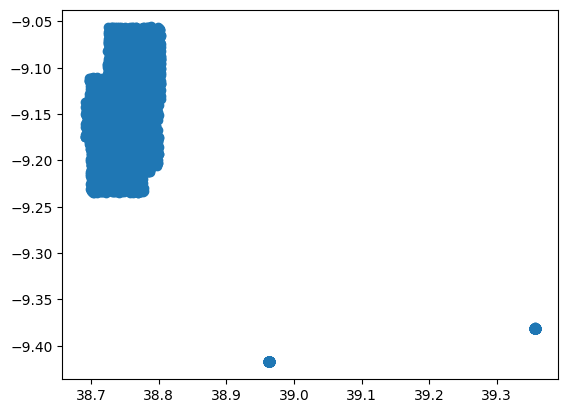

In [7]:
#Plotting longitude and latitude
plt.scatter(x = customer_info["latitude"], y= customer_info["longitude"])
plt.show()

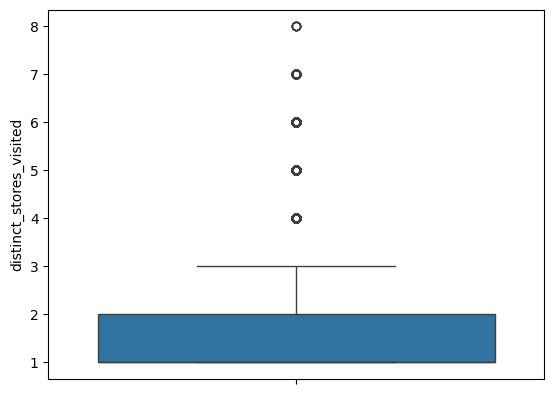

In [8]:
sns.boxplot(data = customer_info, y = "distinct_stores_visited")
plt.show()

In [9]:
customer_info[["lifetime_spend_fish"]]

,lifetime_spend_fish
customer_id,
39634,4056.0
43460,1925.0
23937,2347.0
2431,151.0
10090,172.0
...,...
48487,3779.0
24856,3893.0
21373,142.0


In [10]:
customer_info[["lifetime_spend_fish"]].value_counts()

lifetime_spend_fish
1.0                    3298
0.0                    2624
2.0                     865
3.0                     101
318.0                    42
                       ... 
3079.0                    1
3077.0                    1
3067.0                    1
3065.0                    1
50381.0                   1
Name: count, Length: 4770, dtype: int64

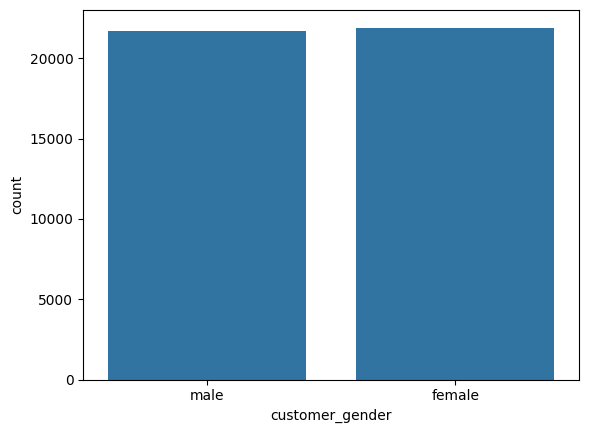

In [11]:
sns.countplot(x='customer_gender', data=customer_info)
plt.show()

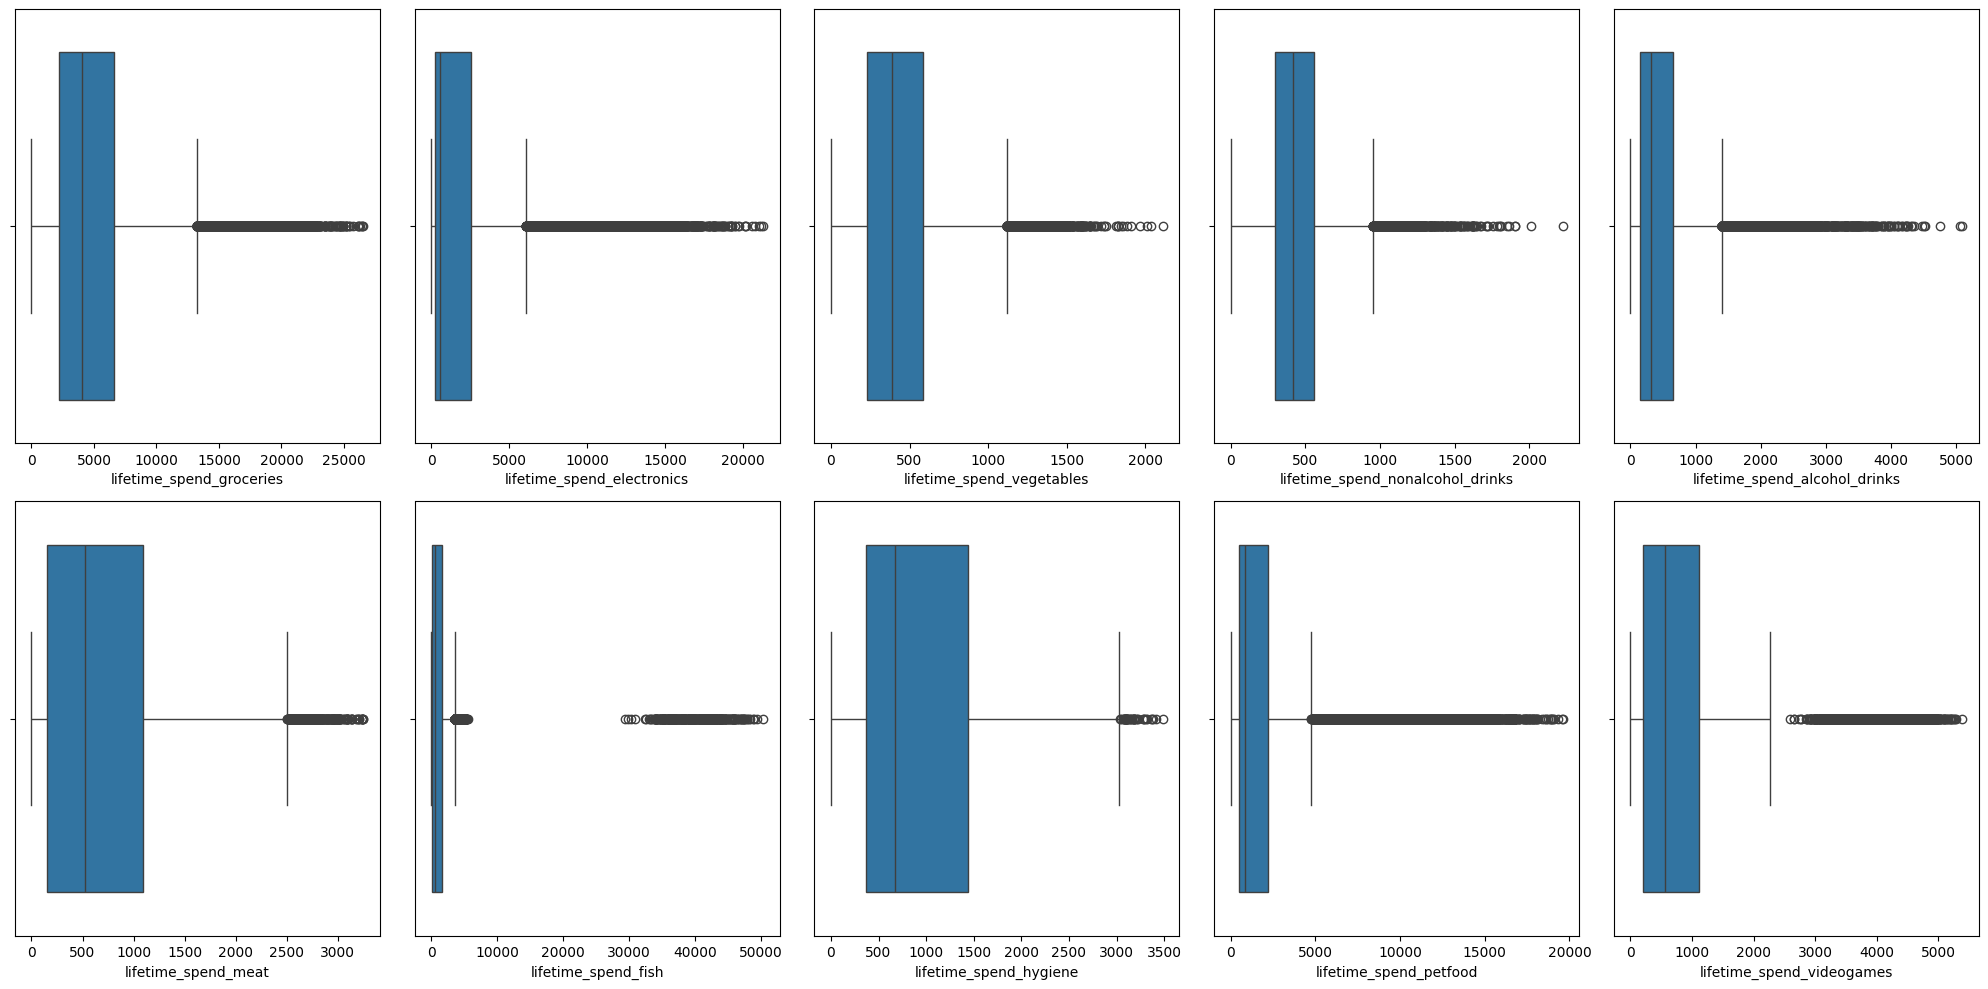

In [15]:
columns = ['lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_vegetables',
           'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
            'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
             'lifetime_spend_petfood', 'lifetime_spend_videogames']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, column in enumerate(columns):
        if i// 5 == 0:
                sns.boxplot(x=customer_info[column], ax=axes[0][i])
        else:
                sns.boxplot(x=customer_info[column], ax=axes[1][i-5])
plt.tight_layout()   
plt.show()

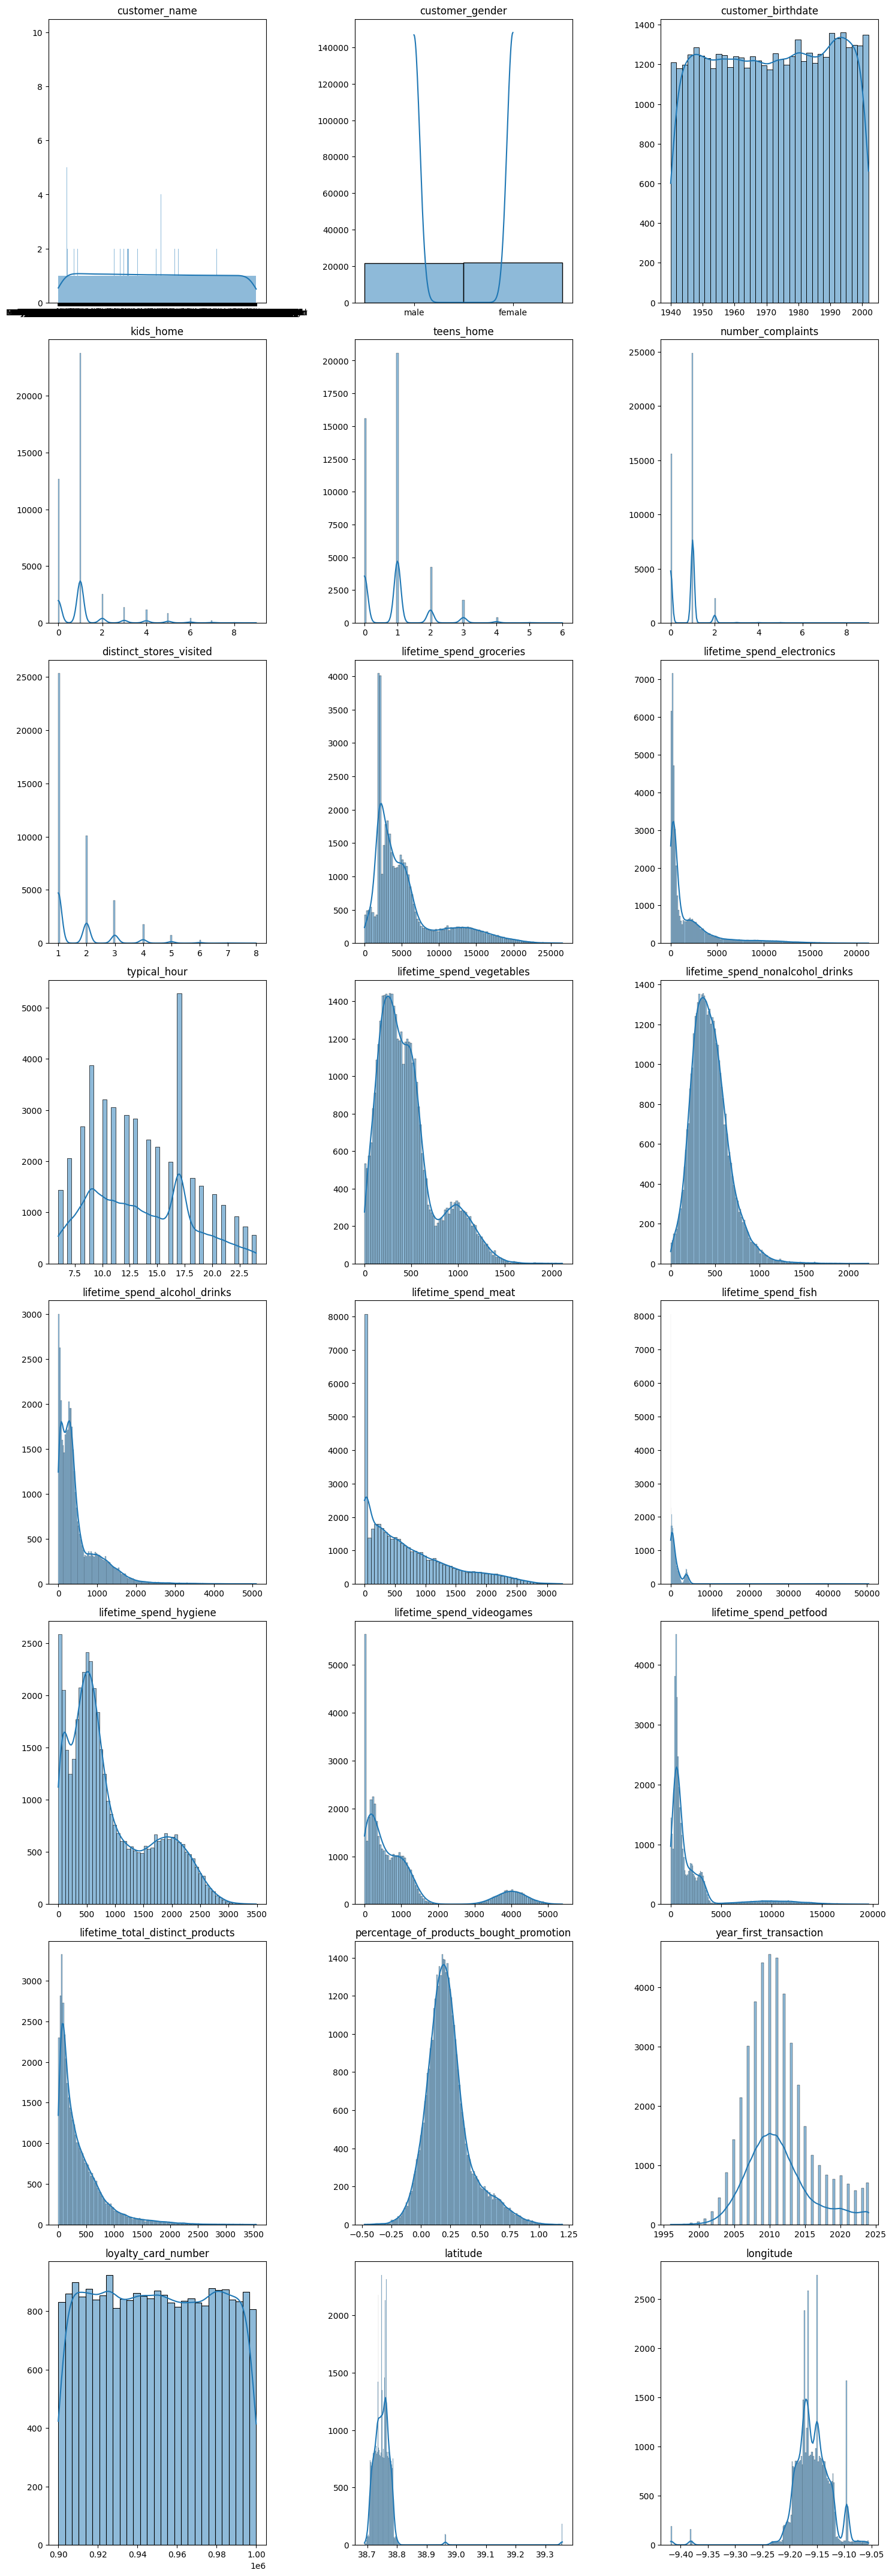

In [16]:
columns_to_visualize = customer_info.columns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(columns_to_visualize)//3 + 1, ncols=3, figsize=(15, len(columns_to_visualize) * 2))

axes = axes.flatten()

# Loop through the columns and create a plot for each
for i, column in enumerate(columns_to_visualize):
    sns.histplot(customer_info[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


# Dealing with some outliers (creating a cluster of just fishermen who spend a lot on fish)

In [5]:
customer_info[customer_info["lifetime_spend_fish"] >6000]

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
48086,Charles`s Fishy,male,1966-09-04 09:18:00,0.0,0.0,1.0,1.0,14998.0,49.0,7.0,...,48432.0,82.0,0.0,0.0,14.0,0.247700,2011.0,NaN,39.356842,-9.380685
31838,Ursula`s Fishy,female,1963-09-20 15:37:00,0.0,0.0,1.0,1.0,13837.0,104.0,9.0,...,45651.0,101.0,0.0,0.0,24.0,-0.038993,2011.0,921411.0,38.963450,-9.417104
41519,Lindsay`s Fishy,female,1956-07-27 18:05:00,0.0,0.0,0.0,1.0,14680.0,167.0,9.0,...,38525.0,148.0,0.0,0.0,33.0,0.399334,2015.0,NaN,38.963252,-9.416521
41076,Carol`s Fishy,female,1942-07-18 08:53:00,0.0,0.0,0.0,1.0,15110.0,357.0,12.0,...,34035.0,80.0,0.0,0.0,34.0,0.282714,2010.0,NaN,39.356766,-9.381005
43120,Rosetta`s Fishy,female,1980-03-30 19:34:00,0.0,0.0,1.0,1.0,16945.0,200.0,9.0,...,39154.0,20.0,0.0,0.0,20.0,0.396175,2011.0,NaN,39.356556,-9.381714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463,Stephanie`s Fishy,female,1956-04-10 18:50:00,0.0,0.0,1.0,1.0,16382.0,77.0,17.0,...,40584.0,136.0,0.0,0.0,7.0,0.228281,2014.0,917861.0,39.357453,-9.381590
12487,Derrick`s Fishy,male,1973-02-20 00:04:00,0.0,0.0,0.0,1.0,17416.0,170.0,17.0,...,40936.0,72.0,0.0,0.0,29.0,0.315183,2003.0,967028.0,38.962869,-9.416967
14727,Tyler`s Fishy,male,1985-01-10 03:28:00,0.0,0.0,1.0,1.0,14184.0,158.0,9.0,...,40034.0,101.0,0.0,0.0,14.0,0.365210,2010.0,936414.0,38.964179,-9.417103


In [6]:
customer_info['Age'] = (pd.to_datetime('2024-05-01') - customer_info['customer_birthdate']).dt.days // 365.25
customer_info

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,Age
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1964-05-15 22:34:00,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,...,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071,59.0
43460,Belinda Terry,female,1988-03-26 23:06:00,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,...,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802,36.0
23937,Evelyn Calico,female,1969-04-13 18:07:00,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,...,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105,55.0
2431,Ora Boggess,female,1941-06-15 03:26:00,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,...,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318,82.0
10090,Lonnie Hopson,male,2001-12-18 03:03:00,0.0,0.0,0.0,1.0,697.0,570.0,NaN,...,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,Amelia Crawford,female,1983-08-28 11:43:00,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,...,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146,40.0
24856,Silvia Ramos,female,1992-09-21 19:16:00,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,...,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643,31.0
21373,Addie Coronel,female,1994-02-20 05:58:00,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,...,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550,30.0


In [7]:
customer_info

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,Age
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1964-05-15 22:34:00,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,...,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071,59.0
43460,Belinda Terry,female,1988-03-26 23:06:00,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,...,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802,36.0
23937,Evelyn Calico,female,1969-04-13 18:07:00,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,...,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105,55.0
2431,Ora Boggess,female,1941-06-15 03:26:00,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,...,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318,82.0
10090,Lonnie Hopson,male,2001-12-18 03:03:00,0.0,0.0,0.0,1.0,697.0,570.0,NaN,...,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48487,Amelia Crawford,female,1983-08-28 11:43:00,1.0,1.0,0.0,1.0,7189.0,6293.0,17.0,...,1748.0,4387.0,2812.0,14.0,0.233259,2016.0,NaN,38.760694,-9.166146,40.0
24856,Silvia Ramos,female,1992-09-21 19:16:00,1.0,1.0,1.0,1.0,11238.0,11490.0,12.0,...,1621.0,3831.0,2726.0,25.0,0.060977,2014.0,909859.0,38.760280,-9.166643,31.0
21373,Addie Coronel,female,1994-02-20 05:58:00,0.0,0.0,0.0,1.0,6059.0,241.0,12.0,...,179.0,0.0,11242.0,44.0,0.097672,2017.0,NaN,38.769923,-9.181550,30.0


# Rebuilding loyalty card and gender variables

In [8]:
customer_info["children"] = customer_info["kids_home"] + customer_info["teens_home"]

In [9]:
customer_info["loyalty_card"] = customer_info["loyalty_card_number"].notnull().astype(int)

In [10]:
customer_info["loyalty_card"]

customer_id
39634    0
43460    0
23937    1
2431     1
10090    1
        ..
48487    0
24856    1
21373    0
19527    1
5120     1
Name: loyalty_card, Length: 43631, dtype: int32

In [11]:
customer_info = pd.get_dummies(customer_info, columns= ["customer_gender"], drop_first= True)

In [12]:
customer_info["customer_gender_male"] = customer_info["customer_gender_male"].apply(lambda x: 1 if x == True else 0)

In [13]:
# Dataframe only for clustering and other preprocessing(for interpretation use customer_info)
customers = customer_info[~customer_info["customer_name"].str.contains("Fishy")]

In [14]:
out_fishermen = customer_info[customer_info["customer_name"].str.contains("Fishy")]

In [15]:
customers = customers.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home", "customer_gender_male", "loyalty_card"])

# Scalling Variables

In [16]:
mm = StandardScaler().fit(customers)
customers_mm = mm.transform(customers)

In [17]:
customers_scalled = pd.DataFrame(customers_mm, columns = customers.columns, index = customers.index)

<Axes: >

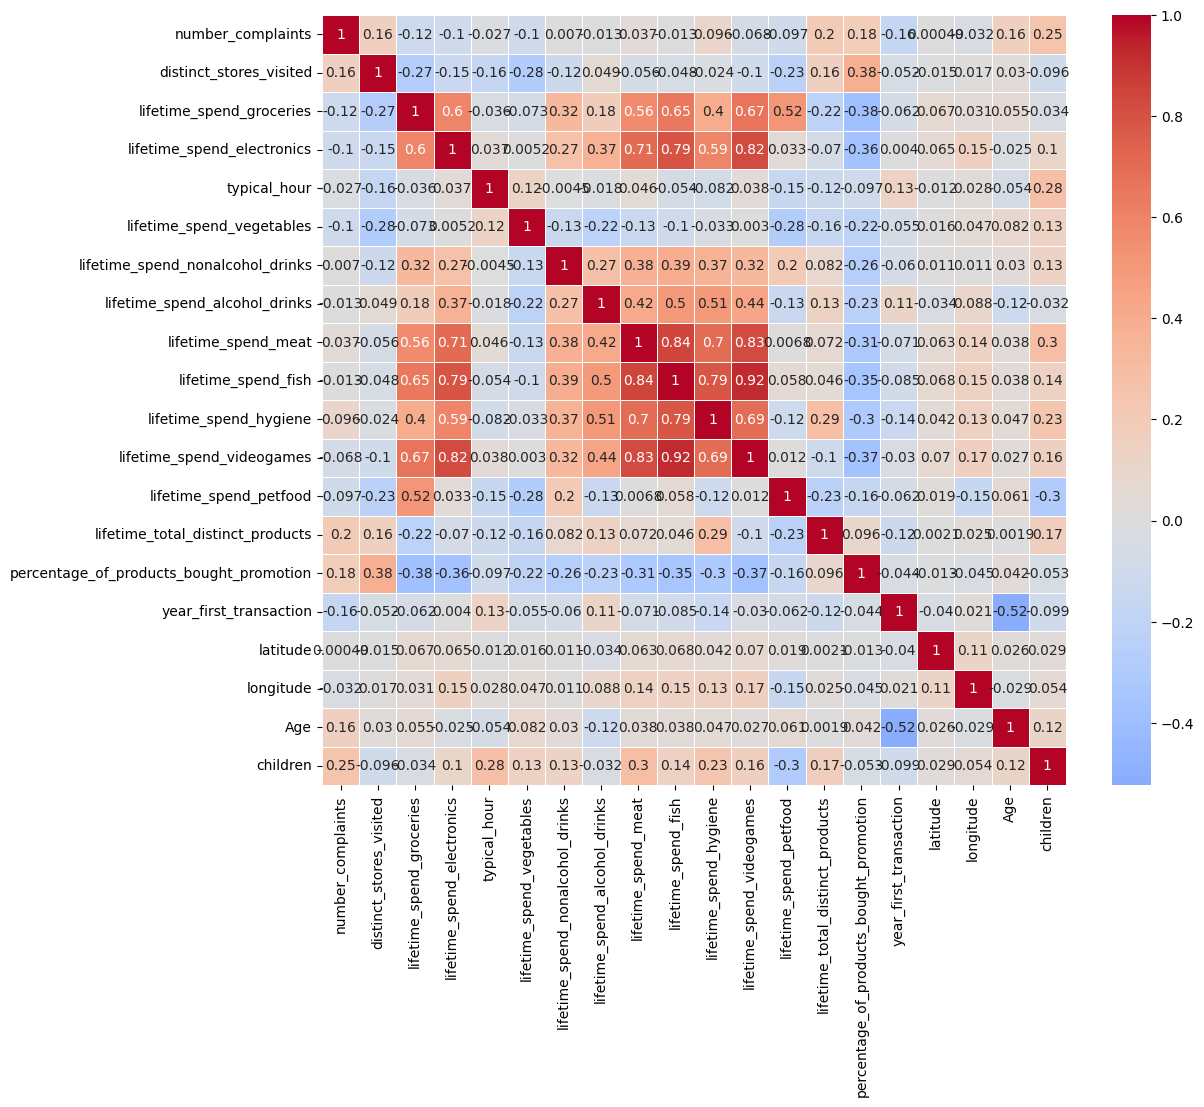

In [18]:
correlation_matrix = customers_scalled.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
    
# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

Fish with high correlation with a lot of variables so we tried to remove it but got worse results

# Imputing Missing Values

In [19]:
knn = KNNImputer(n_neighbors= 5).fit(customers_scalled)
customers_imputed = knn.transform(customers_scalled)

In [20]:
cust_prepoc= pd.DataFrame(customers_imputed, columns = customers.columns, index = customers.index)

In [21]:
cust_prepoc.head()

,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,children
customer_id,,,,,,,,,,,,,,,,,,,,
39634,0.467738,0.312345,2.807064,1.689026,0.757913,0.085110,0.755509,0.847953,2.226344,2.272947,1.714627,2.369484,0.161133,-0.870723,-0.826547,-0.288335,-0.588006,0.256037,0.367547,0.029410
43460,0.467738,0.312345,-0.112231,-0.226431,-1.220451,-0.362074,-0.336332,1.369606,0.520145,0.622019,1.633679,0.023141,-0.018540,5.282871,-0.115169,0.570464,0.644947,-0.151716,-0.908791,-0.522515
23937,0.467738,1.276221,-0.533509,0.682515,-0.780815,-0.499423,1.932799,2.348183,-0.396310,0.948951,0.523729,0.405889,-0.007971,2.164791,-0.487038,-0.503035,-1.417389,-0.301259,0.145576,-0.522515
2431,-1.131408,-0.651530,1.163904,-0.600430,0.757913,-0.972160,-0.915483,-0.833143,-0.633528,-0.752334,-1.195389,-0.803466,0.713789,-0.778443,-0.064080,-0.932435,1.531756,0.212677,1.643886,-1.074439
10090,-1.131408,-0.651530,-1.060655,-0.479967,0.977731,-1.435315,-1.955106,4.446222,-0.973884,-0.736065,-0.462740,-0.624153,-0.674158,-0.938718,-0.248949,2.717463,0.995458,-0.715541,-1.685692,-1.074439


## Prepocessing of fishermen clusters

In [22]:
out_fishermen.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home", "customer_gender_male", "loyalty_card"], inplace = True)

C:\Users\joaof\AppData\Local\Temp\ipykernel_13256\2841812997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_fishermen.drop(columns = ["customer_name", "customer_birthdate", "loyalty_card_number", "teens_home", "kids_home", "customer_gender_male", "loyalty_card"], inplace = True)


In [23]:
fishermen_mm = mm.transform(out_fishermen)
fishermen_scalled = pd.DataFrame(fishermen_mm, columns = out_fishermen.columns, index = out_fishermen.index)
knn = KNNImputer(n_neighbors= 5).fit(fishermen_scalled)
fishermen_imputed = knn.transform(fishermen_scalled)
fishermen_prepoc= pd.DataFrame(fishermen_imputed, columns = out_fishermen.columns, index = out_fishermen.index)

# KMeans clustering

In [24]:
# Calculating the distances in order to find out the optimal number of clusters
dispersion = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cust_prepoc)
    dispersion.append(kmeans.inertia_)

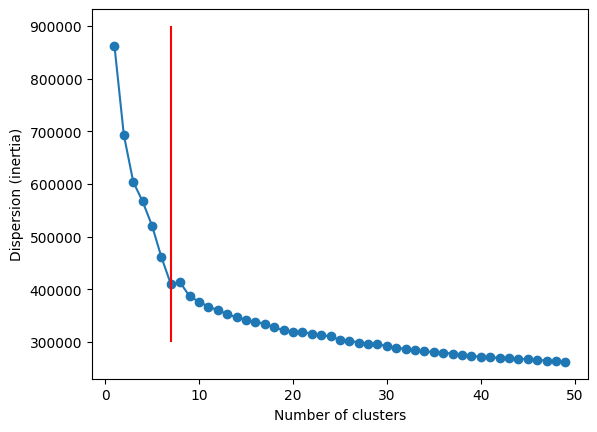

In [33]:
plt.plot(range(1, 50), dispersion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.vlines(7, 300000, 900000, color='red')
plt.show()

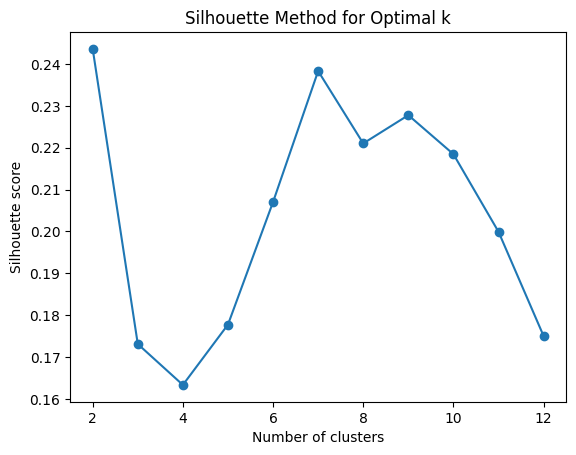

In [26]:
#Plotting the silhouette graph
plot_silhouette(cust_prepoc, max_clusters= 12)

In [27]:
# Create a K-means solution with 100 clusters to then apply the hierarchic clustering to obtain the best number of clusters
cust_copy = cust_prepoc.copy()
kmeans = KMeans(n_clusters=100, random_state=0).fit(cust_prepoc)
cust_copy['cluster_kmeans'] = kmeans.predict(cust_prepoc)

In [28]:
#From the dataset created above (that is a copy of the one after preprocessing) group by centroid 
#so we get the average per centroid to use in the agglomerative clustering

agg_knn = cust_copy.groupby("cluster_kmeans").mean()

In [29]:
# Create the hierarchical algorithm to find the best number of clusters
agg_clust = AgglomerativeClustering(linkage='ward', distance_threshold=0, n_clusters=None).fit(agg_knn)

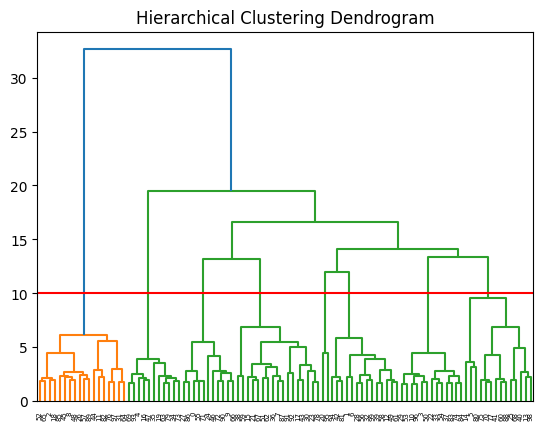

In [31]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_clust, truncate_mode="level", p=50)
plt.axhline(y = 10, color = 'r', linestyle = '-')
plt.show()

In [34]:
kmeans_final = KMeans(n_clusters = 7, random_state=0).fit(cust_prepoc)
cust_prepoc["kmeans_cluster"] = kmeans_final.predict(cust_prepoc)

In [35]:
cust_prepoc.head()

,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,Age,children,kmeans_cluster
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.467738,0.312345,2.807064,1.689026,0.757913,0.085110,0.755509,0.847953,2.226344,2.272947,...,2.369484,0.161133,-0.870723,-0.826547,-0.288335,-0.588006,0.256037,0.367547,0.029410,4
43460,0.467738,0.312345,-0.112231,-0.226431,-1.220451,-0.362074,-0.336332,1.369606,0.520145,0.622019,...,0.023141,-0.018540,5.282871,-0.115169,0.570464,0.644947,-0.151716,-0.908791,-0.522515,0
23937,0.467738,1.276221,-0.533509,0.682515,-0.780815,-0.499423,1.932799,2.348183,-0.396310,0.948951,...,0.405889,-0.007971,2.164791,-0.487038,-0.503035,-1.417389,-0.301259,0.145576,-0.522515,0
2431,-1.131408,-0.651530,1.163904,-0.600430,0.757913,-0.972160,-0.915483,-0.833143,-0.633528,-0.752334,...,-0.803466,0.713789,-0.778443,-0.064080,-0.932435,1.531756,0.212677,1.643886,-1.074439,5
10090,-1.131408,-0.651530,-1.060655,-0.479967,0.977731,-1.435315,-1.955106,4.446222,-0.973884,-0.736065,...,-0.624153,-0.674158,-0.938718,-0.248949,2.717463,0.995458,-0.715541,-1.685692,-1.074439,1


C:\Users\joaof\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


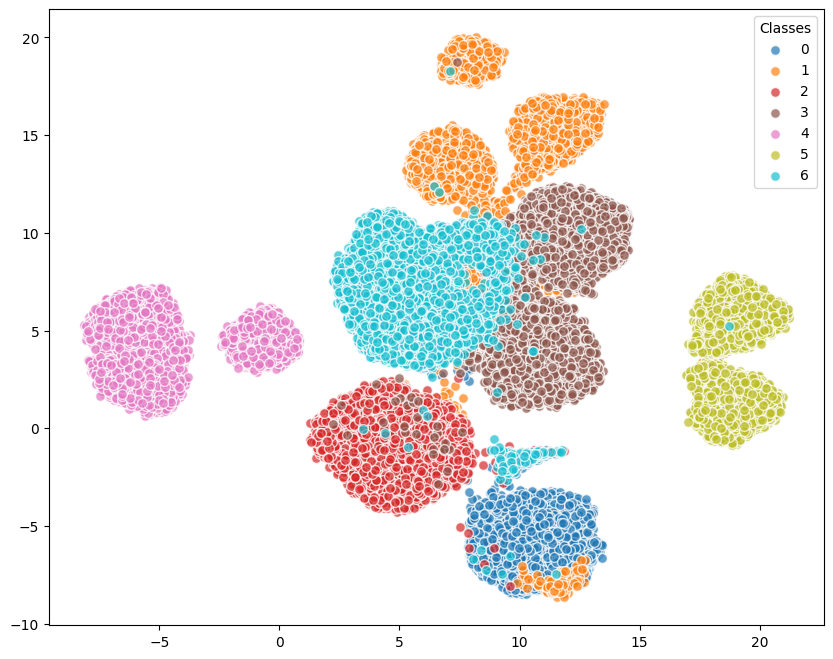

In [36]:
umap_object = umap.UMAP(n_neighbors=15, min_dist=0.7, random_state=0)
cust_prepoc = cust_prepoc.sort_index()
umap_embedding = umap_object.fit_transform(cust_prepoc.iloc[:, :-1])
visualize_dimensionality_reduction_umap(umap_embedding, cust_prepoc.iloc[:,-1].sort_index())